In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11844269665712711105, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214062756
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8274028285964606967
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [23]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.regularizers import l2

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0


In [5]:
batch_size = 32
img_height, img_width = 128, 128
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
train_dir = 'data/train/'
test_dir = 'data/test'

In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.3,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 34909 images belonging to 6 classes.
Found 14958 images belonging to 6 classes.
Found 13578 images belonging to 6 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 34909
nb_validation_samples: 14958
nb_test_samples: 13578

predict_size_train: 1091
predict_size_validation: 468
predict_size_test: 425

 num_classes: 6


In [9]:
# os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "Xception_InceptionV3_descriptors"

In [10]:
# vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
# vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
# resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
# nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
# nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
# mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"

In [11]:
# from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

In [12]:
# input_tensor = Input(shape = input_shape)  

# base_model1=InceptionV3(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
# base_model2=Xception(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

# x1 = base_model1.output
# x1 = GlobalAveragePooling2D()(x1)

# x2 = base_model2.output
# x2 = GlobalAveragePooling2D()(x2)

# merge = concatenate([x1, x2])
# predictions = Dense(num_classes, activation='softmax')(merge)

# model = Model(inputs=input_tensor,outputs=predictions)

In [13]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [14]:
# c1 = model.layers[11].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[21].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[28].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[51].output
# c4 = GlobalAveragePooling2D()(c4) 

# c5 = model.layers[84].output
# c5 = GlobalAveragePooling2D()(c5) 

# c6 = model.layers[103].output
# c6 = GlobalAveragePooling2D()(c6) 

# c7 = model.layers[117].output
# c7 = GlobalAveragePooling2D()(c7) 

# c8 = model.layers[129].output
# c8 = GlobalAveragePooling2D()(c8) 

# c9 = model.layers[143].output
# c9 = GlobalAveragePooling2D()(c9) 

# c10 = model.layers[162].output
# c10 = GlobalAveragePooling2D()(c10) 

# c11 = model.layers[210].output
# c11 = GlobalAveragePooling2D()(c11) 

# c12 = model.layers[258].output
# c12 = GlobalAveragePooling2D()(c12) 

# c13 = model.layers[306].output
# c13 = GlobalAveragePooling2D()(c13) 

# c14 = model.layers[356].output
# c14 = GlobalAveragePooling2D()(c14) 

# c15 = model.layers[377].output
# c15 = GlobalAveragePooling2D()(c15) 

# c16 = model.layers[415].output
# c16 = GlobalAveragePooling2D()(c16) 

# c17 = model.layers[421].output
# c17 = GlobalAveragePooling2D()(c17) 

# con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [15]:
# bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
# np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [16]:
# bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
# np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [17]:
# bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
# np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [18]:

import tensorflow as tf
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))

reset_keras_tf_session()

In [19]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [21]:
dropout_rate = 0.7

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.5, beta_2=0.999)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 34909 samples, validate on 14958 samples
Epoch 1/1000
 - 5s - loss: 0.7025 - acc: 0.7521 - val_loss: 0.7735 - val_acc: 0.6838
Epoch 2/1000
 - 4s - loss: 0.4767 - acc: 0.8317 - val_loss: 0.7501 - val_acc: 0.7129
Epoch 3/1000
 - 4s - loss: 0.4202 - acc: 0.8523 - val_loss: 0.6677 - val_acc: 0.7478
Epoch 4/1000
 - 4s - loss: 0.3895 - acc: 0.8620 - val_loss: 0.6531 - val_acc: 0.7448
Epoch 5/1000
 - 4s - loss: 0.3741 - acc: 0.8692 - val_loss: 0.6960 - val_acc: 0.7286
Epoch 6/1000
 - 4s - loss: 0.3547 - acc: 0.8719 - val_loss: 0.6722 - val_acc: 0.7440
Epoch 7/1000
 - 4s - loss: 0.3408 - acc: 0.8790 - val_loss: 0.6975 - val_acc: 0.7205
Epoch 8/1000
 - 4s - loss: 0.3312 - acc: 0.8812 - val_loss: 0.6440 - val_acc: 0.7484
Epoch 9/1000
 - 4s - loss: 0.3267 - acc: 0.8843 - val_loss: 0.7289 - val_acc: 0.7345
Epoch 10/1000
 - 4s - loss: 0.3179 - acc: 0.8890 - val_loss: 0.6399 - val_acc: 0.7581
Epoch 11/1000
 - 4s - loss: 0.3132 - acc: 0.8881 - val_loss: 0.6319 - val_acc: 0.7664
Epoch 12/1000

Epoch 96/1000
 - 4s - loss: 0.1873 - acc: 0.9320 - val_loss: 0.8817 - val_acc: 0.7390
Epoch 97/1000
 - 4s - loss: 0.1857 - acc: 0.9331 - val_loss: 0.7462 - val_acc: 0.7748
Epoch 98/1000
 - 4s - loss: 0.1848 - acc: 0.9330 - val_loss: 0.7406 - val_acc: 0.7846
Epoch 99/1000
 - 4s - loss: 0.1822 - acc: 0.9333 - val_loss: 0.8427 - val_acc: 0.7688
Epoch 100/1000
 - 4s - loss: 0.1839 - acc: 0.9342 - val_loss: 0.9349 - val_acc: 0.7599
Epoch 101/1000
 - 4s - loss: 0.1870 - acc: 0.9316 - val_loss: 0.8256 - val_acc: 0.7688
Epoch 102/1000
 - 4s - loss: 0.1835 - acc: 0.9341 - val_loss: 0.8652 - val_acc: 0.7610
Epoch 103/1000
 - 4s - loss: 0.1816 - acc: 0.9345 - val_loss: 0.8385 - val_acc: 0.7717
Epoch 104/1000
 - 4s - loss: 0.1812 - acc: 0.9336 - val_loss: 0.9064 - val_acc: 0.7468
Epoch 105/1000
 - 4s - loss: 0.1826 - acc: 0.9337 - val_loss: 0.8329 - val_acc: 0.7644
Epoch 106/1000
 - 4s - loss: 0.1823 - acc: 0.9339 - val_loss: 0.7935 - val_acc: 0.7593
Epoch 107/1000
 - 4s - loss: 0.1822 - acc: 0.93

Epoch 191/1000
 - 4s - loss: 0.1461 - acc: 0.9460 - val_loss: 1.0945 - val_acc: 0.7633
Epoch 192/1000
 - 4s - loss: 0.1523 - acc: 0.9434 - val_loss: 0.9204 - val_acc: 0.7683
Epoch 193/1000
 - 4s - loss: 0.1501 - acc: 0.9447 - val_loss: 1.0216 - val_acc: 0.7726
Epoch 194/1000
 - 4s - loss: 0.1495 - acc: 0.9439 - val_loss: 0.8830 - val_acc: 0.7718
Epoch 195/1000
 - 4s - loss: 0.1495 - acc: 0.9442 - val_loss: 0.9477 - val_acc: 0.7643
Epoch 196/1000
 - 4s - loss: 0.1467 - acc: 0.9465 - val_loss: 1.0824 - val_acc: 0.7511
Epoch 197/1000
 - 4s - loss: 0.1488 - acc: 0.9448 - val_loss: 0.9811 - val_acc: 0.7781
Epoch 198/1000
 - 4s - loss: 0.1472 - acc: 0.9456 - val_loss: 0.9715 - val_acc: 0.7615
Epoch 199/1000
 - 4s - loss: 0.1482 - acc: 0.9451 - val_loss: 0.9313 - val_acc: 0.7726
Epoch 200/1000
 - 4s - loss: 0.1467 - acc: 0.9455 - val_loss: 0.9972 - val_acc: 0.7689
Epoch 201/1000
 - 4s - loss: 0.1460 - acc: 0.9454 - val_loss: 1.0341 - val_acc: 0.7622
Epoch 202/1000
 - 4s - loss: 0.1458 - acc: 

 - 4s - loss: 0.1315 - acc: 0.9503 - val_loss: 1.0422 - val_acc: 0.7699
Epoch 286/1000
 - 4s - loss: 0.1315 - acc: 0.9520 - val_loss: 1.0653 - val_acc: 0.7705
Epoch 287/1000
 - 4s - loss: 0.1290 - acc: 0.9511 - val_loss: 1.2469 - val_acc: 0.7526
Epoch 288/1000
 - 4s - loss: 0.1273 - acc: 0.9521 - val_loss: 1.0616 - val_acc: 0.7710
Epoch 289/1000
 - 4s - loss: 0.1298 - acc: 0.9495 - val_loss: 1.0467 - val_acc: 0.7721
Epoch 290/1000
 - 4s - loss: 0.1312 - acc: 0.9513 - val_loss: 1.0648 - val_acc: 0.7575
Epoch 291/1000
 - 4s - loss: 0.1291 - acc: 0.9520 - val_loss: 1.0737 - val_acc: 0.7693
Epoch 292/1000
 - 4s - loss: 0.1280 - acc: 0.9520 - val_loss: 1.0463 - val_acc: 0.7715
Epoch 293/1000
 - 4s - loss: 0.1297 - acc: 0.9512 - val_loss: 1.1044 - val_acc: 0.7705
Epoch 294/1000
 - 4s - loss: 0.1261 - acc: 0.9526 - val_loss: 1.1153 - val_acc: 0.7725
Epoch 295/1000
 - 4s - loss: 0.1293 - acc: 0.9508 - val_loss: 1.0518 - val_acc: 0.7769
Epoch 296/1000
 - 4s - loss: 0.1287 - acc: 0.9512 - val_lo

Epoch 380/1000
 - 4s - loss: 0.1163 - acc: 0.9557 - val_loss: 1.1589 - val_acc: 0.7689
Epoch 381/1000
 - 4s - loss: 0.1144 - acc: 0.9557 - val_loss: 1.1353 - val_acc: 0.7714
Epoch 382/1000
 - 4s - loss: 0.1133 - acc: 0.9575 - val_loss: 1.4006 - val_acc: 0.7659
Epoch 383/1000
 - 4s - loss: 0.1145 - acc: 0.9568 - val_loss: 1.3043 - val_acc: 0.7598
Epoch 384/1000
 - 4s - loss: 0.1124 - acc: 0.9571 - val_loss: 1.2639 - val_acc: 0.7572
Epoch 385/1000
 - 4s - loss: 0.1130 - acc: 0.9571 - val_loss: 1.3358 - val_acc: 0.7474
Epoch 386/1000
 - 4s - loss: 0.1132 - acc: 0.9564 - val_loss: 1.1344 - val_acc: 0.7608
Epoch 387/1000
 - 4s - loss: 0.1156 - acc: 0.9563 - val_loss: 1.3385 - val_acc: 0.7666
Epoch 388/1000
 - 4s - loss: 0.1147 - acc: 0.9552 - val_loss: 1.2279 - val_acc: 0.7635
Epoch 389/1000
 - 4s - loss: 0.1136 - acc: 0.9572 - val_loss: 1.2630 - val_acc: 0.7558
Epoch 390/1000
 - 4s - loss: 0.1146 - acc: 0.9569 - val_loss: 1.2653 - val_acc: 0.7621
Epoch 391/1000
 - 4s - loss: 0.1132 - acc: 

 - 4s - loss: 0.1052 - acc: 0.9597 - val_loss: 1.2895 - val_acc: 0.7636
Epoch 475/1000
 - 4s - loss: 0.1046 - acc: 0.9612 - val_loss: 1.5074 - val_acc: 0.7615
Epoch 476/1000
 - 4s - loss: 0.1041 - acc: 0.9608 - val_loss: 1.3004 - val_acc: 0.7655
Epoch 477/1000
 - 4s - loss: 0.1020 - acc: 0.9604 - val_loss: 1.4311 - val_acc: 0.7605
Epoch 478/1000
 - 4s - loss: 0.1086 - acc: 0.9576 - val_loss: 1.3104 - val_acc: 0.7569
Epoch 479/1000
 - 4s - loss: 0.1037 - acc: 0.9602 - val_loss: 1.3457 - val_acc: 0.7589
Epoch 480/1000
 - 4s - loss: 0.1062 - acc: 0.9596 - val_loss: 1.3671 - val_acc: 0.7657
Epoch 481/1000
 - 4s - loss: 0.1030 - acc: 0.9606 - val_loss: 1.4387 - val_acc: 0.7536
Epoch 482/1000
 - 4s - loss: 0.1036 - acc: 0.9601 - val_loss: 1.2610 - val_acc: 0.7673
Epoch 483/1000
 - 4s - loss: 0.1050 - acc: 0.9597 - val_loss: 1.3195 - val_acc: 0.7628
Epoch 484/1000
 - 4s - loss: 0.1015 - acc: 0.9615 - val_loss: 1.2266 - val_acc: 0.7779
Epoch 485/1000
 - 4s - loss: 0.1056 - acc: 0.9600 - val_lo

Epoch 569/1000
 - 4s - loss: 0.0958 - acc: 0.9630 - val_loss: 1.3396 - val_acc: 0.7720
Epoch 570/1000
 - 4s - loss: 0.0991 - acc: 0.9625 - val_loss: 1.4188 - val_acc: 0.7635
Epoch 571/1000
 - 4s - loss: 0.0962 - acc: 0.9623 - val_loss: 1.2813 - val_acc: 0.7643
Epoch 572/1000
 - 4s - loss: 0.0941 - acc: 0.9632 - val_loss: 1.6744 - val_acc: 0.7460
Epoch 573/1000
 - 4s - loss: 0.0940 - acc: 0.9631 - val_loss: 1.3935 - val_acc: 0.7669
Epoch 574/1000
 - 4s - loss: 0.0957 - acc: 0.9633 - val_loss: 1.4320 - val_acc: 0.7655
Epoch 575/1000
 - 4s - loss: 0.0954 - acc: 0.9624 - val_loss: 1.5000 - val_acc: 0.7667
Epoch 576/1000
 - 4s - loss: 0.0981 - acc: 0.9619 - val_loss: 1.4597 - val_acc: 0.7568
Epoch 577/1000
 - 4s - loss: 0.0969 - acc: 0.9620 - val_loss: 1.4011 - val_acc: 0.7701
Epoch 578/1000
 - 4s - loss: 0.0976 - acc: 0.9616 - val_loss: 1.3630 - val_acc: 0.7579
Epoch 579/1000
 - 4s - loss: 0.0990 - acc: 0.9619 - val_loss: 1.3812 - val_acc: 0.7695
Epoch 580/1000
 - 4s - loss: 0.0952 - acc: 

 - 4s - loss: 0.0902 - acc: 0.9655 - val_loss: 1.3512 - val_acc: 0.7744
Epoch 664/1000
 - 4s - loss: 0.0935 - acc: 0.9636 - val_loss: 1.4357 - val_acc: 0.7590
Epoch 665/1000
 - 4s - loss: 0.0907 - acc: 0.9652 - val_loss: 1.4420 - val_acc: 0.7676
Epoch 666/1000
 - 4s - loss: 0.0901 - acc: 0.9656 - val_loss: 1.5699 - val_acc: 0.7680
Epoch 667/1000
 - 4s - loss: 0.0904 - acc: 0.9646 - val_loss: 1.5726 - val_acc: 0.7560
Epoch 668/1000
 - 4s - loss: 0.0930 - acc: 0.9633 - val_loss: 1.4720 - val_acc: 0.7565
Epoch 669/1000
 - 4s - loss: 0.0909 - acc: 0.9643 - val_loss: 1.5584 - val_acc: 0.7593
Epoch 670/1000
 - 4s - loss: 0.0962 - acc: 0.9632 - val_loss: 1.4096 - val_acc: 0.7537
Epoch 671/1000
 - 4s - loss: 0.0871 - acc: 0.9657 - val_loss: 1.4382 - val_acc: 0.7712
Epoch 672/1000
 - 4s - loss: 0.0908 - acc: 0.9652 - val_loss: 1.4497 - val_acc: 0.7633
Epoch 673/1000
 - 4s - loss: 0.0929 - acc: 0.9642 - val_loss: 1.3956 - val_acc: 0.7649
Epoch 674/1000
 - 4s - loss: 0.0904 - acc: 0.9642 - val_lo

Epoch 758/1000
 - 4s - loss: 0.0838 - acc: 0.9677 - val_loss: 1.4629 - val_acc: 0.7707
Epoch 759/1000
 - 4s - loss: 0.0866 - acc: 0.9661 - val_loss: 1.5989 - val_acc: 0.7508
Epoch 760/1000
 - 4s - loss: 0.0876 - acc: 0.9652 - val_loss: 1.5604 - val_acc: 0.7722
Epoch 761/1000
 - 4s - loss: 0.0848 - acc: 0.9665 - val_loss: 1.4956 - val_acc: 0.7579
Epoch 762/1000
 - 4s - loss: 0.0872 - acc: 0.9648 - val_loss: 1.5522 - val_acc: 0.7680
Epoch 763/1000
 - 4s - loss: 0.0840 - acc: 0.9665 - val_loss: 1.6031 - val_acc: 0.7687
Epoch 764/1000
 - 4s - loss: 0.0862 - acc: 0.9666 - val_loss: 1.4988 - val_acc: 0.7638
Epoch 765/1000
 - 4s - loss: 0.0888 - acc: 0.9661 - val_loss: 1.5462 - val_acc: 0.7703
Epoch 766/1000
 - 4s - loss: 0.0847 - acc: 0.9669 - val_loss: 1.5405 - val_acc: 0.7696
Epoch 767/1000
 - 4s - loss: 0.0861 - acc: 0.9656 - val_loss: 1.5735 - val_acc: 0.7695
Epoch 768/1000
 - 4s - loss: 0.0869 - acc: 0.9657 - val_loss: 1.5974 - val_acc: 0.7599
Epoch 769/1000
 - 4s - loss: 0.0841 - acc: 

 - 4s - loss: 0.0843 - acc: 0.9661 - val_loss: 1.5933 - val_acc: 0.7579
Epoch 853/1000
 - 4s - loss: 0.0792 - acc: 0.9683 - val_loss: 1.5332 - val_acc: 0.7627
Epoch 854/1000
 - 4s - loss: 0.0818 - acc: 0.9673 - val_loss: 1.6009 - val_acc: 0.7683
Epoch 855/1000
 - 4s - loss: 0.0868 - acc: 0.9674 - val_loss: 1.5837 - val_acc: 0.7621
Epoch 856/1000
 - 4s - loss: 0.0800 - acc: 0.9684 - val_loss: 1.7007 - val_acc: 0.7617
Epoch 857/1000
 - 4s - loss: 0.0810 - acc: 0.9687 - val_loss: 1.5623 - val_acc: 0.7645
Epoch 858/1000
 - 4s - loss: 0.0822 - acc: 0.9679 - val_loss: 1.5424 - val_acc: 0.7699
Epoch 859/1000
 - 4s - loss: 0.0802 - acc: 0.9687 - val_loss: 1.5613 - val_acc: 0.7649
Epoch 860/1000
 - 4s - loss: 0.0816 - acc: 0.9685 - val_loss: 1.5943 - val_acc: 0.7618
Epoch 861/1000
 - 4s - loss: 0.0831 - acc: 0.9671 - val_loss: 1.5808 - val_acc: 0.7611
Epoch 862/1000
 - 4s - loss: 0.0808 - acc: 0.9684 - val_loss: 1.5901 - val_acc: 0.7591
Epoch 863/1000
 - 4s - loss: 0.0795 - acc: 0.9693 - val_lo

Epoch 947/1000
 - 4s - loss: 0.0783 - acc: 0.9688 - val_loss: 1.6316 - val_acc: 0.7651
Epoch 948/1000
 - 4s - loss: 0.0813 - acc: 0.9673 - val_loss: 1.5503 - val_acc: 0.7660
Epoch 949/1000
 - 4s - loss: 0.0815 - acc: 0.9670 - val_loss: 1.7300 - val_acc: 0.7596
Epoch 950/1000
 - 4s - loss: 0.0735 - acc: 0.9707 - val_loss: 1.7290 - val_acc: 0.7613
Epoch 951/1000
 - 4s - loss: 0.0771 - acc: 0.9700 - val_loss: 1.6266 - val_acc: 0.7603
Epoch 952/1000
 - 4s - loss: 0.0790 - acc: 0.9689 - val_loss: 1.6825 - val_acc: 0.7634
Epoch 953/1000
 - 4s - loss: 0.0779 - acc: 0.9706 - val_loss: 1.6074 - val_acc: 0.7651
Epoch 954/1000
 - 4s - loss: 0.0770 - acc: 0.9689 - val_loss: 1.6162 - val_acc: 0.7696
Epoch 955/1000
 - 4s - loss: 0.0795 - acc: 0.9686 - val_loss: 1.5914 - val_acc: 0.7671
Epoch 956/1000
 - 4s - loss: 0.0802 - acc: 0.9689 - val_loss: 1.6489 - val_acc: 0.7672
Epoch 957/1000
 - 4s - loss: 0.0773 - acc: 0.9696 - val_loss: 1.6475 - val_acc: 0.7623
Epoch 958/1000
 - 4s - loss: 0.0833 - acc: 

In [38]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8902636618058625


Confusion Matrix
[[2624    3    9    4  102  184]
 [   2  472    7   13   14   11]
 [   1    5 2620   20   31  402]
 [   0   25   49  969   23   31]
 [   5   22   66   10 2643   83]
 [  16    6  242   29   75 2760]]


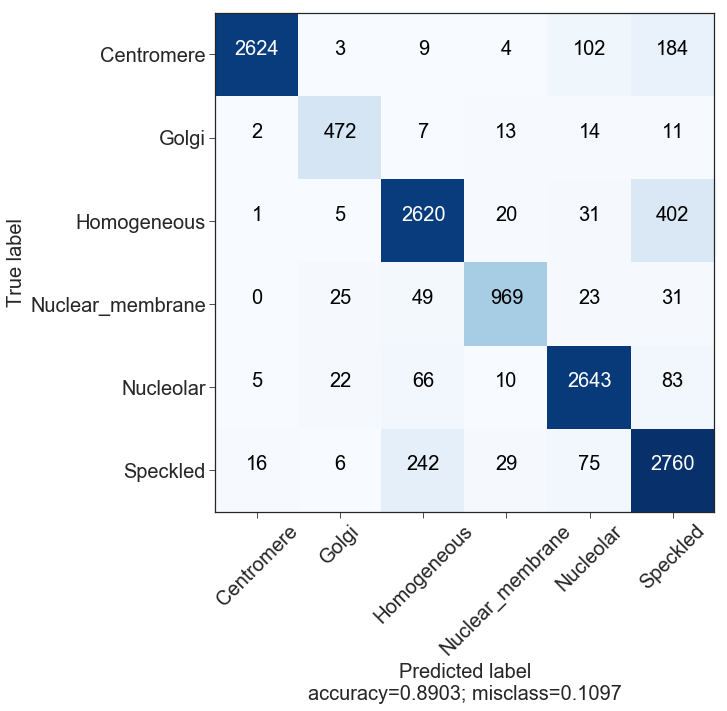

In [39]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[2624    3    9    4  102  184]
 [   2  472    7   13   14   11]
 [   1    5 2620   20   31  402]
 [   0   25   49  969   23   31]
 [   5   22   66   10 2643   83]
 [  16    6  242   29   75 2760]]
                  precision    recall  f1-score   support

      Centromere       0.99      0.90      0.94      2926
       Nucleolar       0.89      0.91      0.90       519
Nuclear_membrane       0.88      0.85      0.86      3079
     Homogeneous       0.93      0.88      0.90      1097
           Golgi       0.92      0.93      0.92      2829
        Speckled       0.80      0.88      0.84      3128

       micro avg       0.89      0.89      0.89     13578
       macro avg       0.90      0.89      0.89     13578
    weighted avg       0.89      0.89      0.89     13578



In [41]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.9992383853769993
Specificity :  0.9936842105263158


In [45]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

13578/13578 [==============================] - 0s 32us/step
Precision =  0.8946714148379473
Recall =  0.8902636618058625
f1_score =  0.8913305957452885


In [46]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9303141248795054


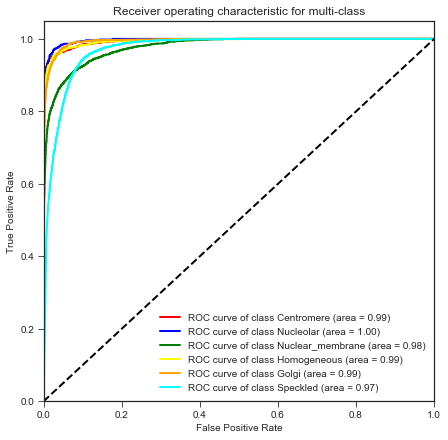

In [49]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

predict_class = np.argmax(preds, axis=1)

y_pred = preds
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4, 5])
y_pred_binary = y_pred_probabilities
n_classes=6
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

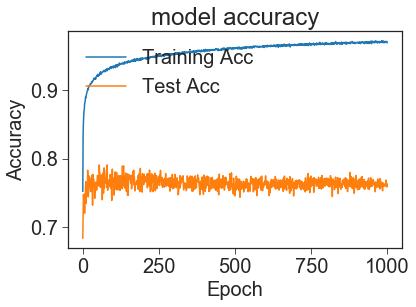

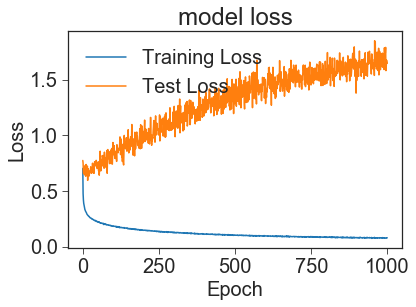

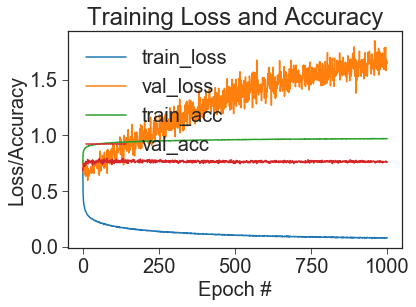

In [34]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")